 Project Name    : Machine Learning
 
 File Name       : Trial.ipynb
 
 Creation Date   : Jun 9 2022
 
 Copyright (c) 2021 KAMAKE no SUSUME. All rights reserved.
 
 This source code or any portion thereof must not be reproduced or used in any manner whatsoever.

In [ ]:
#Google colab上でインターンのコーディングしてました。
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab/Trial

/content/drive/MyDrive/Colab/Trial


In [ ]:
%run prepare_images.py datasets/mydata

Copied images from datasets/mydata/tomato
Copied images from datasets/mydata/cabbage
Copied images from datasets/mydata/pepper
Copied images from datasets/mydata/apple
Copied images from datasets/mydata/pineapple　
Copied images from datasets/mydata/potato
Copied images from datasets/mydata/broccoli　
Copied images from datasets/mydata/Avocado 


In [ ]:
%run prepare_images.py datasets/

Copied images from datasets/dice_top_crop/3
Copied images from datasets/dice_top_crop/5
Copied images from datasets/dice_top_crop/2
Copied images from datasets/dice_top_crop/4
Copied images from datasets/dice_top_crop/1
Copied images from datasets/dice_top_crop/6


In [ ]:

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import shutil
import math
from IPython.display import Image as IPImage
from IPython.display import display_jpeg
import visualize

print(tf.__version__)

train_dir = 'target_datasets/train'#訓練データ
val_dir = 'target_datasets/val'#テストデータ

backup_dir = './model'
#os.path.join(train_dir, d)が存在すれば、os.path.isdirがtrueを返す。
labels = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
labels.sort()

#ファイルやディレクトリ（フォルダ）が存在するかどうかを確認
if os.path.exists(backup_dir):
    #shutil.rmtree()は中身ごと指定のディレクトリを削除
    shutil.rmtree(backup_dir)

#ディレクトリを再帰的に作成する
os.makedirs(backup_dir)

# labelsのlabelをファイルbackup_dirに書き込む
with open(backup_dir + '/labels.txt','w') as f:
    for label in labels:
        f.write(label+"\n")

NUM_CLASSES = len(labels) #8 野菜の種類
print("class number=" + str(NUM_CLASSES))

labels = []
with open(backup_dir + '/labels.txt','r') as f:
    for line in f:
        labels.append(line.rstrip())
print(labels)

2.6.0
correct.txt  incorrect.txt  model.png          __pycache__/      Trial.ipynb
datasets/    model/         prepare_images.py  target_datasets/  visualize.py
class number=8
['Avocado', 'apple', 'broccoli', 'cabbage', 'pepper', 'pineapple', 'potato', 'tomato']


Found 230 images belonging to 8 classes.
Found 56 images belonging to 8 classes.
## Train Data Sample ##


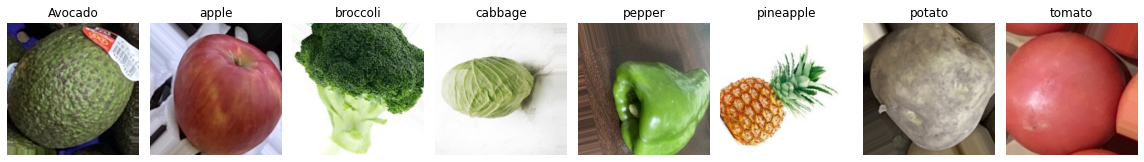

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 200, 200, 8)       224       
_________________________________________________________________
activation_6 (Activation)    (None, 200, 200, 8)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 198, 198, 8)       584       
_________________________________________________________________
activation_7 (Activation)    (None, 198, 198, 8)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 196, 196, 8)       584       
_________________________________________________________________
activation_8 (Activation)    (None, 196, 196, 8)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 194, 194, 6)      

In [ ]:
# 学習率
LEARNING_RATE = 0.001
# エポック（世代数)。重み更新を何回行うか。
EPOCHS = 35
# バッチサイズ
#ミニバッチ勾配降下法は、ランダムに選んだBATCH_SIZE個のサンプルで損失を計算した勾配でパラメータを更新
BATCH_SIZE = 16

IMAGE_SIZE = 200 #ImageSize128:0.71
#rescale
#画像はRGB(Red,Green,Blue)で表され、それぞれ0~255の値を取る
#例：RGB =（110,15,40)
#255で割ることでそれぞれの要素が0~1という小さな値になりモデルにとって処理しやすい　
#例：RGB =（0.43,0.05,0.15)
#rotation_range : 画像をランダムに回転する回転範囲．
#width_shift_range=0.1：画像の横幅の10分の1の長さだけ画像をランダムに水平シフトする。
#height_shift_range=0.1：画像の縦幅の10分の1の長さだけ画像をランダムに垂直シフトする。
train_data_gen = ImageDataGenerator(rescale=1./255,rotation_range=180,width_shift_range=0.1,height_shift_range=0.1)
#train_data_gen = ImageDataGenerator(rescale=1./255, rotation_range=180)
val_data_gen = ImageDataGenerator(rescale=1./255)

#print(train_data_gen)
#print(val_data_gen)

# メモ：ImageDataGenerator.flow_from_directory はIteratorを返す
train_data = train_data_gen.flow_from_directory(
    train_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb', batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True)

validation_data = val_data_gen.flow_from_directory(
    val_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb', batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False)

# Display train data sample
visualize.pick_train_sample(labels, train_data)

# AI model definition
model = Sequential()

#縦横ピクセル3x3のフィルタを8枚使って畳み込みをしなさい。
model.add(Conv2D(8, (3, 3), padding='same',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Activation('relu'))
model.add(Conv2D(8, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(8, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(6, (3, 3)))
model.add(Activation('relu'))
#入力画像内の「2×2」の領域で最大の数値を出力する。
model.add(MaxPooling2D(pool_size=(2, 2)))
#全結合の層とのつながりを「20%」無効化
model.add(Dropout(0.2))
#平坦化（次元削減） – 1次元ベクトルに変換する。
model.add(Flatten())
#全結合層。出力128。
#活性化関数「ReLU（Rectified Linear Unit）- ランプ関数」。入力が0以下の時は出力0。入力が0より大きい場合はそのまま出力する。
model.add(Dense(128))
model.add(Activation('relu'))
#全結合の層とのつながりを「20%」無効化
model.add(Dropout(0.2))
#出力8（0~7の10クラス判定のため）
#Denseのところで、畳み込みニューラルネットワーク（CNN）の最終的な全結合層の出力次元数の決め方は、判定するクラス数を指定
model.add(Dense(NUM_CLASSES))
#Softmax関数で総和が1となるように、各出力の予測確率を計算
model.add(Activation('softmax'))
#lr = 学習率
opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
#opt = tf.keras.optimizers.SGD(lr=LEARNING_RATE)

#損失関数は交差エントロピー
model.compile(opt, loss='categorical_crossentropy',
    metrics=['accuracy'])
#モデルの概要を表示
model.summary()

# Execute train
#verbose: 0, 1または2．詳細表示モード．0とすると標準出力にログを出力しません． 1の場合はログをプログレスバーで標準出力，2の場合はエポックごとに1行のログを出力します．
history = model.fit(train_data, epochs=EPOCHS, validation_data=validation_data, verbose=1)

score = model.evaluate(validation_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Prediction data
[[0.645 0.001 0.188 0.021 0.008 0.137 0.    0.   ]
 [0.302 0.015 0.581 0.005 0.    0.097 0.    0.   ]
 [0.357 0.011 0.465 0.064 0.065 0.037 0.    0.   ]
 [0.998 0.001 0.    0.    0.    0.    0.    0.   ]
 [0.998 0.    0.    0.    0.002 0.    0.    0.   ]
 [0.857 0.015 0.004 0.003 0.003 0.056 0.063 0.   ]
 [0.999 0.    0.    0.    0.    0.    0.    0.   ]
 [0.997 0.    0.001 0.001 0.    0.    0.    0.   ]
 [0.    0.373 0.    0.    0.092 0.    0.    0.534]
 [0.    0.795 0.    0.    0.003 0.    0.    0.202]
 [0.    0.989 0.    0.    0.    0.    0.001 0.009]
 [0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.998 0.    0.    0.    0.    0.    0.002]
 [0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.985 0.    0.    0.002 0.    0.    0.013]
 [0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.106 0.    0.001 0.028 0.    0.012 0.852]
 [0.    0.349 0.    0.    0.193 0.    0.    0.458]
 [0.    0.001 0

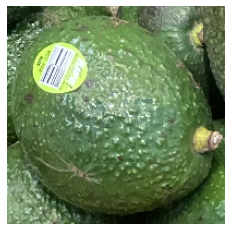

#2 Expected:Avocado -> Predicted:broccoli
File: Avocado /アボガドtra16.jpg
Each Prediction Value: [0.357 0.011 0.465 0.064 0.065 0.037 0.    0.   ]
**** INCORRECT ****


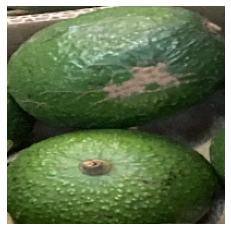

#3 Expected:Avocado -> Predicted:Avocado
File: Avocado /アボガドtra2.jpg
Each Prediction Value: [0.998 0.001 0.    0.    0.    0.    0.    0.   ]
* Correct *
#4 Expected:Avocado -> Predicted:Avocado
File: Avocado /アボガドtra24.jpg
Each Prediction Value: [0.998 0.    0.    0.    0.002 0.    0.    0.   ]
* Correct *
#5 Expected:Avocado -> Predicted:Avocado
File: Avocado /アボガドval3.jpg
Each Prediction Value: [0.857 0.015 0.004 0.003 0.003 0.056 0.063 0.   ]
* Correct *
#6 Expected:Avocado -> Predicted:Avocado
File: Avocado /アボガドval6.jpg
Each Prediction Value: [0.999 0.    0.    0.    0.    0.    0.    0.   ]
* Correct *
#7 Expected:Avocado -> Predicted:Avocado
File: Avocado /アボガドval7.jpg
Each Prediction Value: [0.997 0.    0.001 0.001 0.    0.    0.    0.   ]
* Correct *
#8 Expected:apple -> Predicted:tomato
File: apple/87ec5e060e72e5c103bbf3d6e9c7bb52_t (1).jpeg
Each Prediction Value: [0.    0.373 0.    0.    0.092 0.    0.    0.534]
**** INCORRECT ****


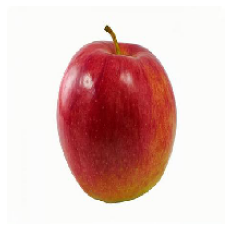

#9 Expected:apple -> Predicted:apple
File: apple/appletra2.jpg
Each Prediction Value: [0.    0.795 0.    0.    0.003 0.    0.    0.202]
* Correct *
#10 Expected:apple -> Predicted:apple
File: apple/appletra6.jpg
Each Prediction Value: [0.    0.989 0.    0.    0.    0.    0.001 0.009]
* Correct *
#11 Expected:apple -> Predicted:apple
File: apple/appleval1 (1).jpg
Each Prediction Value: [0. 1. 0. 0. 0. 0. 0. 0.]
* Correct *
#12 Expected:apple -> Predicted:apple
File: apple/appleval10.jpg
Each Prediction Value: [0.    0.998 0.    0.    0.    0.    0.    0.002]
* Correct *
#13 Expected:apple -> Predicted:apple
File: apple/appleval2 (1).jpg
Each Prediction Value: [0. 1. 0. 0. 0. 0. 0. 0.]
* Correct *
#14 Expected:apple -> Predicted:apple
File: apple/appleval3 (2).jpg
Each Prediction Value: [0. 1. 0. 0. 0. 0. 0. 0.]
* Correct *
#15 Expected:apple -> Predicted:apple
File: apple/appleval4 (1).jpg
Each Prediction Value: [0.    0.985 0.    0.    0.002 0.    0.    0.013]
* Correct *
#16 Expected:

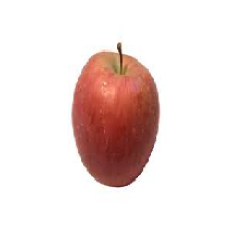

#18 Expected:apple -> Predicted:tomato
File: apple/images-16.jpeg
Each Prediction Value: [0.    0.349 0.    0.    0.193 0.    0.    0.458]
**** INCORRECT ****


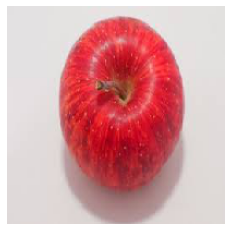

#19 Expected:broccoli -> Predicted:broccoli
File: broccoli　/ブロッコリーval5.jpg
Each Prediction Value: [0.    0.001 0.995 0.002 0.    0.002 0.    0.   ]
* Correct *
#20 Expected:cabbage -> Predicted:cabbage
File: cabbage/キャベツ1.jpg
Each Prediction Value: [0.001 0.    0.021 0.827 0.004 0.026 0.12  0.001]
* Correct *
#21 Expected:cabbage -> Predicted:cabbage
File: cabbage/キャベツ14val (1).jpg
Each Prediction Value: [0.    0.    0.006 0.989 0.004 0.    0.    0.   ]
* Correct *
#22 Expected:cabbage -> Predicted:cabbage
File: cabbage/キャベツ15.jpg
Each Prediction Value: [0. 0. 0. 1. 0. 0. 0. 0.]
* Correct *
#23 Expected:cabbage -> Predicted:cabbage
File: cabbage/キャベツ1val2.jpg
Each Prediction Value: [0.    0.    0.213 0.787 0.    0.    0.    0.   ]
* Correct *
#24 Expected:cabbage -> Predicted:cabbage
File: cabbage/キャベツ6val (1).jpg
Each Prediction Value: [0.    0.    0.022 0.977 0.001 0.    0.    0.   ]
* Correct *
#25 Expected:cabbage -> Predicted:cabbage
File: cabbage/キャベツ8val (1).jpg
Each Pred

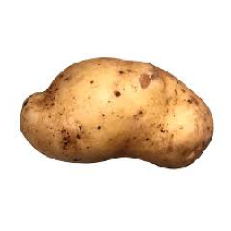

#45 Expected:potato -> Predicted:potato
File: potato/ジャガイモ29val4.jpg
Each Prediction Value: [0.    0.    0.    0.    0.    0.    0.999 0.   ]
* Correct *
#46 Expected:potato -> Predicted:potato
File: potato/ジャガイモ29val8.jpg
Each Prediction Value: [0.    0.    0.    0.    0.001 0.    0.997 0.001]
* Correct *
#47 Expected:tomato -> Predicted:tomato
File: tomato/images-44.jpeg
Each Prediction Value: [0.    0.031 0.    0.    0.007 0.    0.    0.962]
* Correct *
#48 Expected:tomato -> Predicted:tomato
File: tomato/images-45.jpeg
Each Prediction Value: [0.    0.045 0.    0.001 0.013 0.    0.003 0.938]
* Correct *
#49 Expected:tomato -> Predicted:tomato
File: tomato/トマト10.jpg
Each Prediction Value: [0.    0.026 0.    0.001 0.008 0.001 0.002 0.962]
* Correct *
#50 Expected:tomato -> Predicted:tomato
File: tomato/トマト2.png
Each Prediction Value: [0.    0.148 0.    0.001 0.09  0.    0.    0.761]
* Correct *
#51 Expected:tomato -> Predicted:tomato
File: tomato/トマト29val2.jpg
Each Prediction Valu

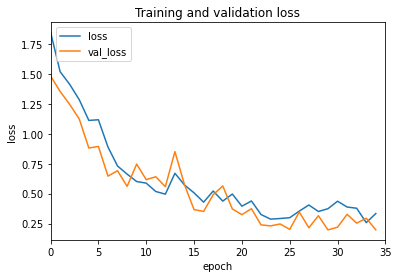

Accuracy


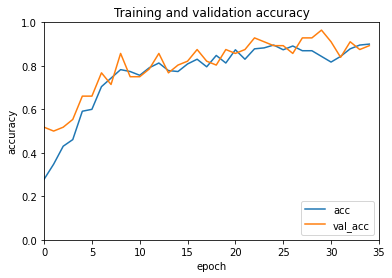

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12288 missing from current font.
  font.set_text(s, 0, flags=flags)


Confusion Matrix


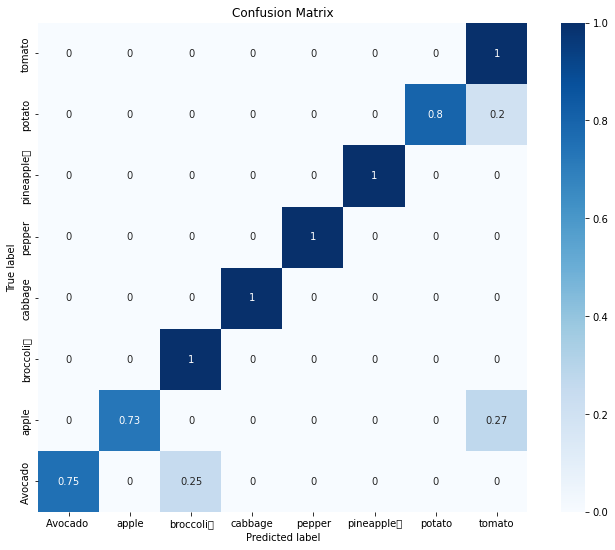

In [ ]:
# Failed pictures
visualize.vis_failed_pic(model, labels, validation_data, val_dir, BATCH_SIZE, 100)

# Visualize loss
visualize.vis_loss_accuracy(history, EPOCHS)

# Save model
save_model_path = os.path.join(backup_dir, 'my_model.h5')
model.save(save_model_path)

# Confusion Matrix
visualize.vis_confusion_matrix(model, validation_data)

In [ ]:
visualize.vis_filter(model, 'conv2d')#1層目の畳み込み層を表示
visualize.vis_filter(model, 'conv2d_1')#2層目の畳み込み層を表示
visualize.vis_filter(model, 'conv2d_2')#3層目の畳み込み層を表示
visualize.vis_filter(model, 'conv2d_3')#4層目の畳み込み層を表示

Visualize filter: conv2d


ValueError: ignored

In [ ]:
!cat incorrect.txt

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 200, 200, 8)       224       
_________________________________________________________________
activation_6 (Activation)    (None, 200, 200, 8)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 198, 198, 8)       584       
_________________________________________________________________
activation_7 (Activation)    (None, 198, 198, 8)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 196, 196, 8)       584       
_________________________________________________________________
activation_8 (Activation)    (None, 196, 196, 8)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 194, 194, 6)      

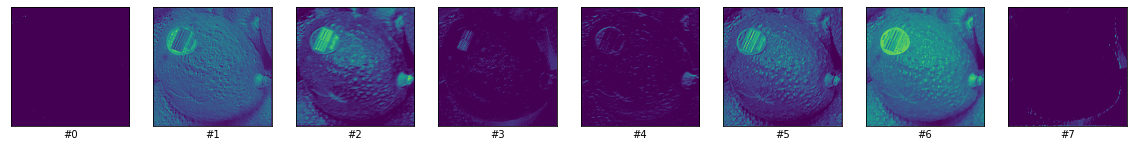

target_datasets/val/Avocado /アボガドtra16.jpg


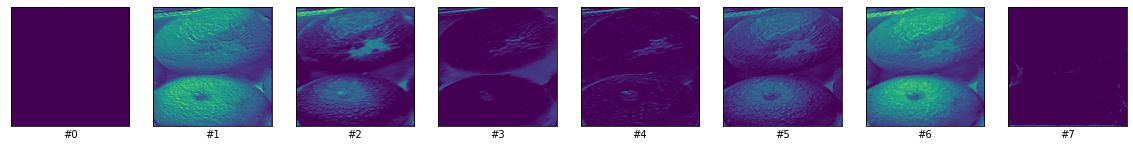

target_datasets/val/apple/87ec5e060e72e5c103bbf3d6e9c7bb52_t (1).jpeg


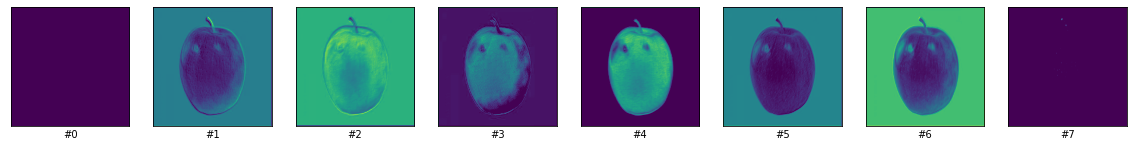

target_datasets/val/apple/images-14.jpeg


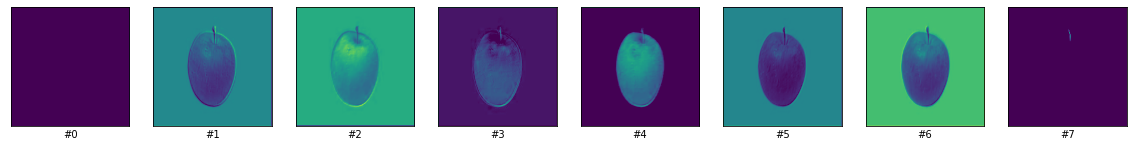

target_datasets/val/apple/images-16.jpeg


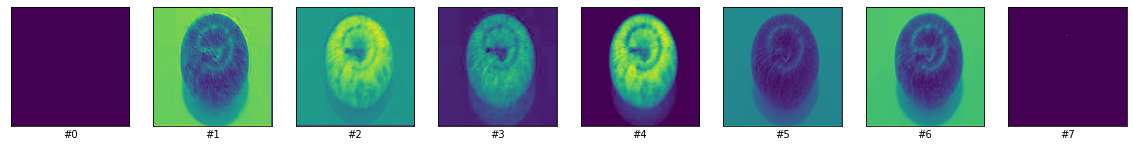

target_datasets/val/potato/images-25.jpeg


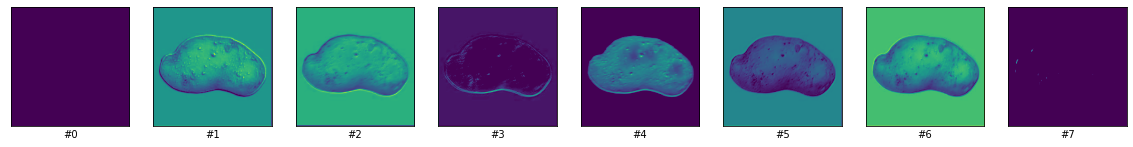

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 200, 200, 8)       224       
_________________________________________________________________
activation_6 (Activation)    (None, 200, 200, 8)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 198, 198, 8)       584       
_________________________________________________________________
activation_7 (Activation)    (None, 198, 198, 8)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 196, 196, 8)       584       
_________________________________________________________________
activation_8 (Activation)    (None, 196, 196, 8)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 194, 194, 6)      

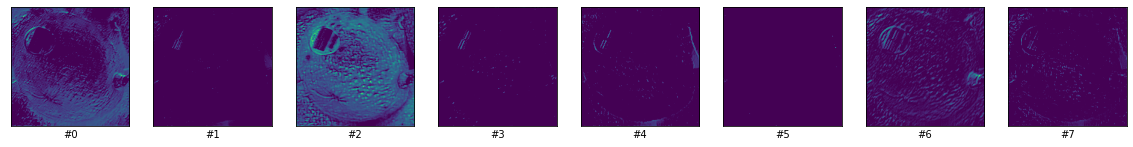

target_datasets/val/Avocado /アボガドtra16.jpg


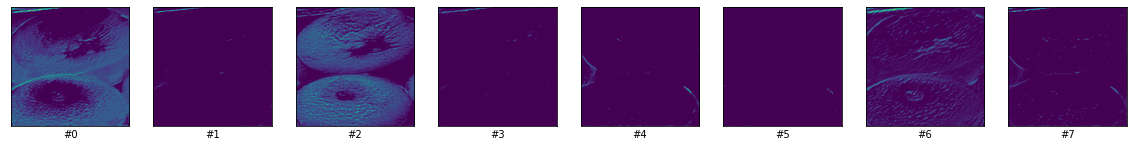

target_datasets/val/apple/87ec5e060e72e5c103bbf3d6e9c7bb52_t (1).jpeg


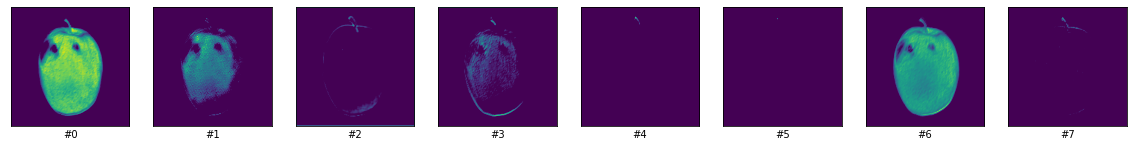

target_datasets/val/apple/images-14.jpeg


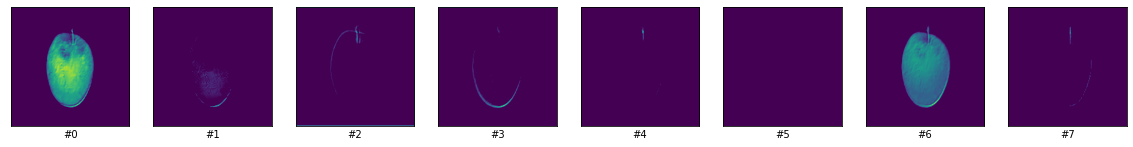

target_datasets/val/apple/images-16.jpeg


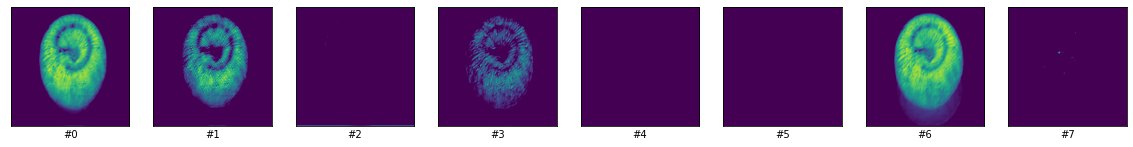

target_datasets/val/potato/images-25.jpeg


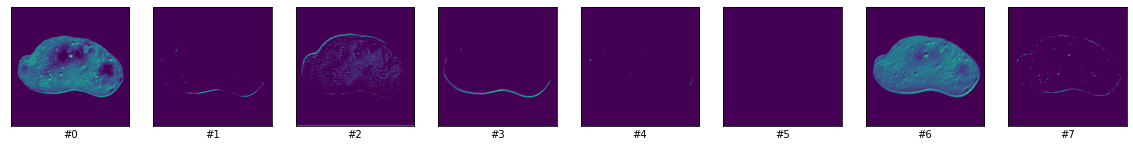

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 200, 200, 8)       224       
_________________________________________________________________
activation_6 (Activation)    (None, 200, 200, 8)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 198, 198, 8)       584       
_________________________________________________________________
activation_7 (Activation)    (None, 198, 198, 8)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 196, 196, 8)       584       
_________________________________________________________________
activation_8 (Activation)    (None, 196, 196, 8)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 194, 194, 6)      

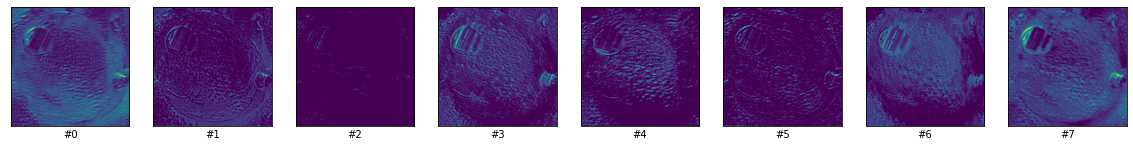

target_datasets/val/Avocado /アボガドtra16.jpg


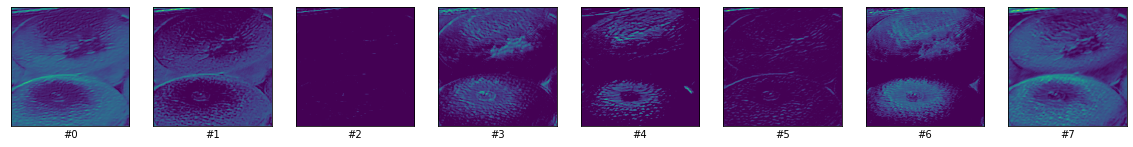

target_datasets/val/apple/87ec5e060e72e5c103bbf3d6e9c7bb52_t (1).jpeg


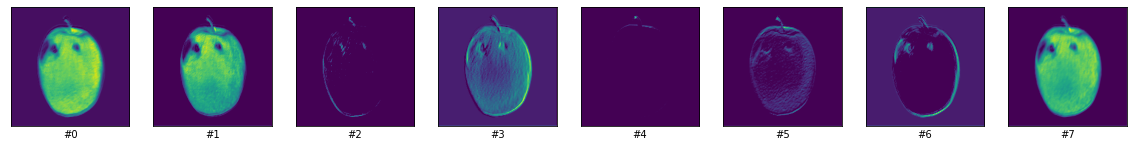

target_datasets/val/apple/images-14.jpeg


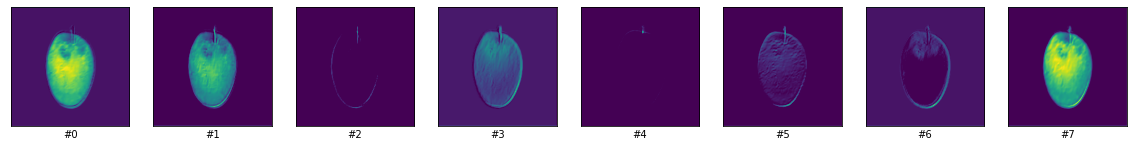

target_datasets/val/apple/images-16.jpeg


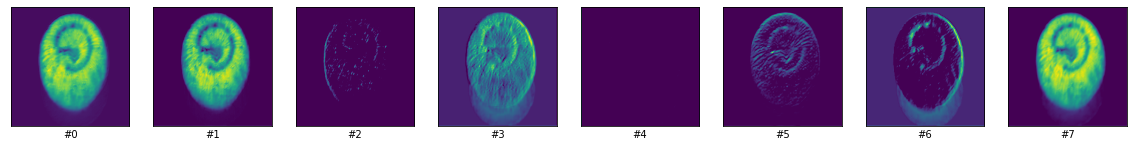

target_datasets/val/potato/images-25.jpeg


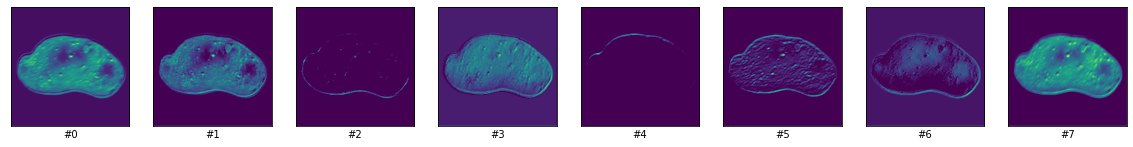

In [ ]:
#それぞれの畳み込み層で誤って識別した物を表示
visualize.vis_hidden_layer('incorrect.txt', 'activation_6', IMAGE_SIZE)
#visualize.vis_hidden_layer('correct.txt', 'activation_1', IMAGE_SIZE)
visualize.vis_hidden_layer('incorrect.txt', 'activation_7', IMAGE_SIZE)
#visualize.vis_hidden_layer('correct.txt', 'activation_2', IMAGE_SIZE)
visualize.vis_hidden_layer('incorrect.txt', 'activation_8', IMAGE_SIZE)
#visualize.vis_hidden_layer('correct.txt', 'activation_3', IMAGE_SIZE)

画像サイズを大きくすると、計算時間が増える。(層のノード数大、モデルパラメーター数大)
画素数減らして精度向上したが、これは画像サイズ大きすぎると畳み込みで局所的な特徴しか抜け出せないからか？いや違う。

6、８枚のフィルターがそれぞれ異なる特徴を抜き出すはずだが、同じような特徴を抜き出したり、特徴がない(黒色で潰れている)のもある。
ずれ0、畳み込み層3個(accuracyは0.7ぐらい？)からをズレを0.1にし回転を加えるとaccuracyが
1回目：0.9、2回目：1.0、3回目:0.95

デフォルト(batch size=128)からbatch size=512に変えてみた(畳み込み層の個数は3のまま)test losの振動って、batchの偏りとかに依存してそうだし。batchを大きくとれば安定するんじゃね？)
結果：
1回目：1.0(0.86~1の間で振動した、batch128とあまり変わらんか？)
2回目：0.95
